# MACHINE LEARNING

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imutils
import glob
import os
import sys
import time
import tensorflow as tf

## 1. Module Machine Learning
* https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_table_of_contents_ml/py_table_of_contents_ml.html
* https://docs.opencv.org/4.x/dd/ded/group__ml.html#ga9c57a2b823008dda53d2c7f7059a8710
* cv2.ml_KNearest()
* cv2.ml_SVM()
* cv2.ml_Dtrees()
* cv2.ml_LogisticRegression()
* cv2.kmeans()

In [11]:
dig = cv2.imread('DATA/raw/digits.png')
gray = cv2.cvtColor(dig,cv2.COLOR_BGR2GRAY)

# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Make it into a Numpy array. It size will be (50,100,20,20)
x = np.array(cells)

# Now we prepare train_data and test_data.
train = x[:,:50].reshape(-1,400).astype(np.float32) # Size = (2500,400)
test = x[:,50:100].reshape(-1,400).astype(np.float32) # Size = (2500,400)

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k,250)[:,np.newaxis]
test_labels = train_labels.copy()

# Initiate kNN, train the data, then test it with test data for k=1
knn = cv2.ml.KNearest_create()
knn.train(train,0,train_labels)
ret,result,neighbours,dist = knn.findNearest(test,k=5)

# Now we check the accuracy of classification
# For that, compare the result with test_labels and check which are wrong
matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print(accuracy)

91.76


In [51]:
dig = cv2.imread('DATA/raw/digits.png')
gray = cv2.cvtColor(dig,cv2.COLOR_BGR2GRAY)

# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Make it into a Numpy array. It size will be (50,100,20,20)
x = np.array(cells)

# Now we prepare train_data and test_data.
train = x[:,:50].reshape(-1,400).astype(np.float32) # Size = (2500,400)
test = x[:,50:100].reshape(-1,400).astype(np.float32) # Size = (2500,400)

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k,250)[:,np.newaxis]
test_labels = train_labels.copy()

# Train the SVM
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm.train(train, cv2.ml.ROW_SAMPLE, train_labels)

_,result = svm.predict(test)

matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print(accuracy)

90.2


In [60]:
dig = cv2.imread('DATA/raw/digits.png')
gray = cv2.cvtColor(dig,cv2.COLOR_BGR2GRAY)

# Now we split the image to 5000 cells, each 20x20 size
cells = [np.hsplit(row,100) for row in np.vsplit(gray,50)]

# Make it into a Numpy array. It size will be (50,100,20,20)
x = np.array(cells)

# Now we prepare train_data and test_data.
train = x[:,:50].reshape(-1,400).astype(np.float32) # Size = (2500,400)
test = x[:,50:100].reshape(-1,400).astype(np.float32) # Size = (2500,400)

# Create labels for train and test data
k = np.arange(10)
train_labels = np.repeat(k,250)[:,np.newaxis]
test_labels = train_labels.copy()

dt = cv2.ml.DTrees_create()
dt.setMaxDepth(7)
dt.setCVFolds(1)
dt.train(train, cv2.ml.DTREES_PREDICT_AUTO, train_labels)

_, result = dt.predict(test)

matches = result==test_labels
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print(accuracy)

71.08


## 2. PCA and SVD

## 3. Module Deep Neural Network
* cv2.dnn.ClassificationModel()
* cv2.dnn.DetectionModel()
* cv2.dnn.SegmetaionModel()
* cv2.dnn.TextDetectionModel()
* cv2.dnn.TextRecognitionModel()
* cv2.dnn.blobFromImage()
* cv2.dnn.readNetFromDarknet()
* cv2.dnn.readNetFromTensorflow()
* cv2.dnn.readNetFromTorch()
* cv2.dnn.readNetFromCaffe()

### 3.1 Read Net from framework
* cv2.dnn.blobFromImage(): preprocess image for the model
* cv2.dnn.readNetFromDarknet()
* cv2.dnn.readNetFromTensorflow()
* cv2.dnn.readNetFromTorch()
* cv2.dnn.readNetFromCaffe()

### 3.1.1 Caffe

In [296]:
# Split all the classes by a new line and store it in variable called rows.
with open('model/synset_words.txt') as f:
    rows = f.read().strip().split("\n")

# Check the number of classes.
print("Number of Classes "+str(len(rows)))

# Show the first 5 rows
print(rows[0:5])

Number of Classes 1000
['n01440764 tench, Tinca tinca', 'n01443537 goldfish, Carassius auratus', 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'n01491361 tiger shark, Galeocerdo cuvieri', 'n01494475 hammerhead, hammerhead shark']


In [297]:
# Split by comma after first space is found and grabb the first element and store it in a new list.
CLASSES = [r[r.find(" ") + 1:].split(",")[0] for r in rows]

# Print the first 20 processed class labels 
print(CLASSES[0:20])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee']


In [210]:
def init_classify_caffe(weights_name = 'DenseNet_121.caffemodel', architecture_name = 'DenseNet_121.prototxt.txt'):
    
    # Set global variables
    global classes
    
    base_path = 'model'
    
    # Read the Classes
    rows = open(os.path.join(base_path,'synset_words.txt')).read().strip().split("\n")

    # Load and split  the classes
    classes = [r[r.find(" ") + 1:].split(",")[0] for r in rows]
    
    # Load the wieght and architeture of the model
    weights = os.path.join(base_path, weights_name)
    architecture = os.path.join(base_path, architecture_name)
    
    # Intialize the model
    net = cv2.dnn.readNetFromCaffe(architecture, weights)
    return net

In [211]:
cf_net = init_classify_caffe()

In [258]:
image = cv2.imread('DATA/dnnimages/spcar.JPG')

In [259]:
blob = cv2.dnn.blobFromImage(image, 0.017, (224, 224), (103.94,116.78,123.68))

In [260]:
cf_net.setInput(blob)

In [261]:
Output_cf = cf_net.forward()

In [262]:
new_Output_cf = Output_cf.reshape(len(Output_cf[0][:]))

In [276]:
new_Output_cf

array([-1.05152941e+00,  9.81131375e-01, -2.71671057e+00, -3.02093267e+00,
       -6.82308257e-01, -1.39515448e+00, -5.47559440e-01,  7.57523060e-01,
       -3.67392898e-02,  1.55871701e+00, -4.12973881e+00, -1.22862041e+00,
       -1.14400423e+00, -3.87549758e+00, -3.40032554e+00, -1.57155073e+00,
       -4.06973553e+00, -3.70032430e+00, -2.64096451e+00, -1.42335987e+00,
       -2.92443633e+00,  1.80468380e+00,  6.96013391e-01,  7.67643392e-01,
       -8.92856121e-01, -1.37507051e-01, -1.19860291e+00,  6.52385831e-01,
       -7.96588898e-01, -1.61996508e+00, -3.76162529e-01, -8.58003795e-01,
        6.79978490e-01,  2.94125766e-01,  7.07303882e-01, -1.58432677e-01,
        5.87572932e-01,  1.97494358e-01, -1.17769146e+00, -1.40730011e+00,
       -3.89208883e-01, -1.79973662e+00, -4.46154401e-02, -2.35046196e+00,
       -1.34635186e+00, -1.77025807e+00, -1.22744608e+00, -2.89537954e+00,
       -1.35764897e-01, -5.20945072e-01, -2.04496574e+00, -9.29264963e-01,
        2.35437489e+00,  

In [233]:
def classify_caffe(image, returndata=False, size=1,):
    
    # Pre-process the image
    blob = cv2.dnn.blobFromImage(image, 0.017, (224, 224), (103.94,116.78,123.68))
    
    # Input blob image into network
    cf_net.setInput(blob)
    
    # Forward pass
    Output = cf_net.forward()
    
    # Reshape the Output so its a single dimensional vector
    new_Output = Output.reshape(len(Output[0][:]))
    
    # Convert the scores to class probabilities between 0-1.
    expanded = np.exp(new_Output - np.max(new_Output))
    prob =  expanded / expanded.sum()
    print(prob.max())
    # Get Highest probable class.
    conf= np.max(prob)
    
    # Index of Class with the maximum Probability.
    index = np.argmax(prob)

    # Name of the Class with the maximum probability   
    label = classes[index]   

    text = "Label: {}, {:.2f}%".format(label, conf*100)

    cv2.putText(image, text, (5, size*26),  cv2.FONT_HERSHEY_COMPLEX, size, (100, 20, 255), 3)
        
    if  returndata:
        return image, text
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off")
    return prob

0.74358267


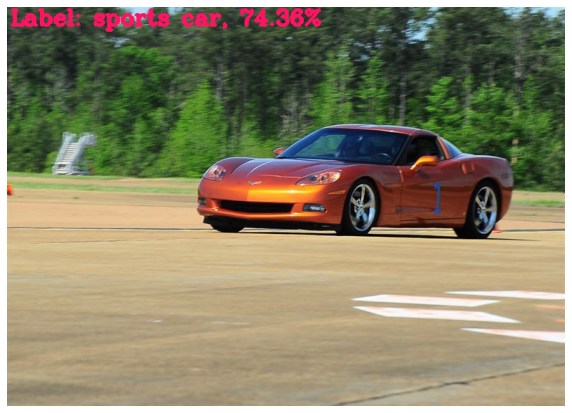

In [234]:
image = cv2.imread('DATA/dnnimages/spcar.JPG')
cf_prob = classify_caffe(image)

0.79237753


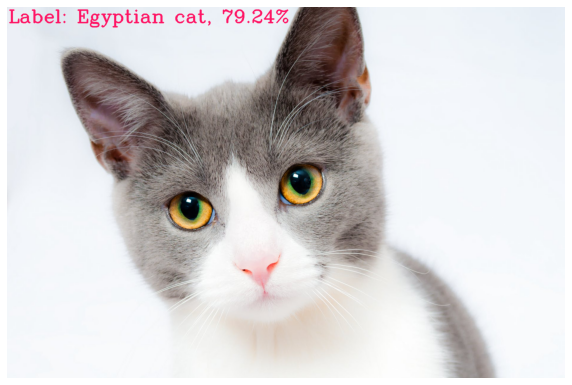

In [226]:
image = cv2.imread('DATA/dnnimages/cat.jpeg')
classify_caffe(image,size=2)

### 3.2.2 Tensorflow

In [207]:
tf_net = cv2.dnn.readNetFromTensorflow('model/DenseNet121.pb')

In [293]:
def classify_tf(image, returndata=False, size=1,net = tf_net):
    
    # Pre-process the image
    blob = cv2.dnn.blobFromImage(image, 0.017, (224, 224), (103.94,116.78,123.68))
    
    # Input blob image into network
    net.setInput(blob)
    
    # Forward pass
    Output = net.forward()
    
    # Reshape the Output so its a single dimensional vector
    new_Output = Output[0]
    
    # Convert the scores to class probabilities between 0-1.
    
    prob =  new_Output
    
    # Get Highest probable class.
    conf= np.max(prob)
    
    # Index of Class with the maximum Probability.
    index = np.argmax(prob)

    # Name of the Class with the maximum probability   
    label = classes[index]   

    text = "Label: {}, {:.2f}%".format(label, conf*100)

    cv2.putText(image, text, (5, size*26),  cv2.FONT_HERSHEY_COMPLEX, size, (100, 20, 255), 3)
        
    if  returndata:
        return image, text
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off")
    

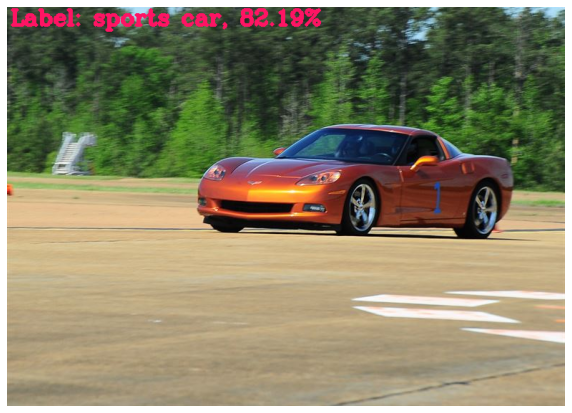

In [294]:
image = cv2.imread('DATA/dnnimages/spcar.JPG')
classify_tf(image)

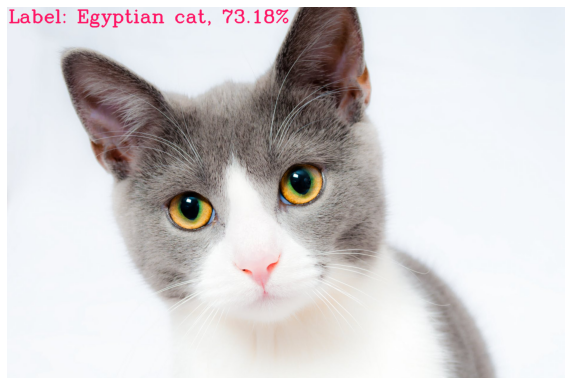

In [295]:
image = cv2.imread('DATA/dnnimages/cat.jpeg')
classify_tf(image,size=2)

### 3.1.3: Pytorch

In [298]:
toc_net = cv2.dnn.readNetFromONNX('model/DenseNet121.onnx')

In [314]:
def classify_toc(image, returndata=False, size=1,net = toc_net):
    
    # Pre-process the image
    blob = cv2.dnn.blobFromImage(image, 0.017, (224, 224), (103.94,116.78,123.68))
    
    # Input blob image into network
    net.setInput(blob)
    
    # Forward pass
    Output = net.forward()
    
    # Reshape the Output so its a single dimensional vector
    new_Output = Output[0]
    
    # Convert the scores to class probabilities between 0-1.
    expanded = np.exp(new_Output - np.max(new_Output))
    prob =  expanded / expanded.sum()
    
    
    # Get Highest probable class.
    conf= np.max(prob)
    
    # Index of Class with the maximum Probability.
    index = np.argmax(prob)

    # Name of the Class with the maximum probability   
    label = classes[index]   

    text = "Label: {}, {:.2f}%".format(label, conf*100)

    cv2.putText(image, text, (5, size*26),  cv2.FONT_HERSHEY_COMPLEX, size, (100, 20, 255), 3)
        
    if  returndata:
        return image, text
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off")

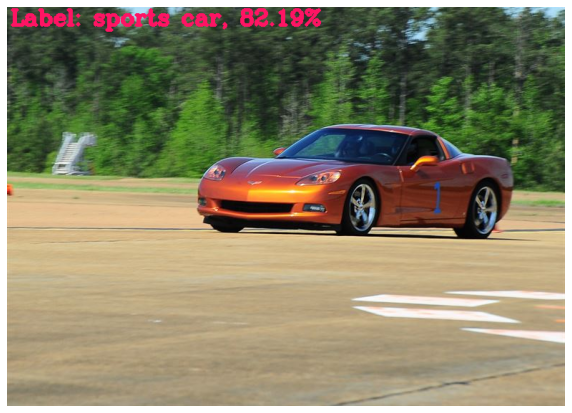

In [315]:
image = cv2.imread('DATA/dnnimages/spcar.JPG')
classify_toc(image)

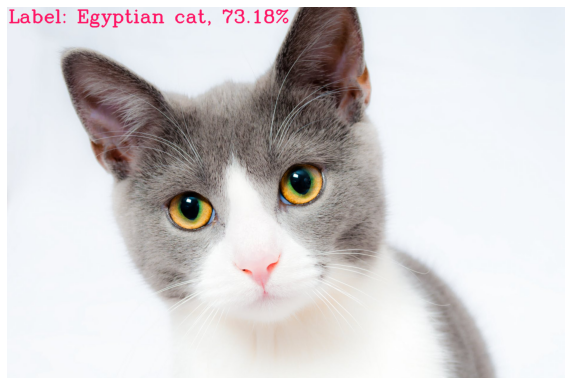

In [316]:
image = cv2.imread('DATA/dnnimages/cat.jpeg')
classify_toc(image,size=2)